In [1]:
"""
Two-Stage-To-Orbit Design Problem with Environmental Optimization
Modified to minimize Life Cycle Assessment (LCA) score instead of GLOW

L. BREVAULT (ONERA/DTIS), M. BALESDENT (ONERA/DTIS)
Modified for environmental optimization
"""

import numpy as np
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Import OpenMDAO + CMA-ES optimization algorithm
import openmdao.api as om
import cma

# Import specific Python functions for launch vehicle design
import Launch_vehicle_Group
import post_traitement
import result_vizualization

✓ Brightway2 and ecoinvent successfully loaded


In [2]:
def setup_baseline_problem():
    """Create problem with baseline configuration"""
    P = om.Problem()
    P.model = Launch_vehicle_Group.Launcher_vehicle()
    P.setup(check=False)
    
    # Fixed trajectory parameters from CMA-ES optimization
    lowerbnd = np.array([150., 20., 0., -10., -1., 5., 5., 1., 10., 10.])
    upperbnd = np.array([600., 200., 50., 20., 1., 20., 20., 10., 70., 70.])
    x_optimal = np.array([0.23527546, 0.36153667, 0.39784285, 0.53903249, 
                         0.22424615, 0.96230176, 0.75167229, 0.8693451, 
                         0.44461484, 0.17382506])
    XX = lowerbnd + (upperbnd - lowerbnd) * x_optimal
    
    # Set fixed parameters
    P['Diameter_stage_1'] = 5.0
    P['Diameter_stage_2'] = 5.0
    P['Mass_flow_rate_stage_1'] = 300.
    P['Mass_flow_rate_stage_2'] = 200.
    P['Thrust_stage_1'] = 1000.
    P['Thrust_stage_2'] = 1000.
    P['OF_stage_1'] = 5.0
    P['OF_stage_2'] = 5.5
    P['Pc_stage_1'] = 80.
    P['Pc_stage_2'] = 60.
    P['Pe_stage_1'] = 1.0
    P['Pe_stage_2'] = 1.0
    P['N_eng_stage_1'] = 6.
    P['N_eng_stage_2'] = 1.
    
    # Fixed trajectory
    P['Prop_mass_stage_1'] = XX[0] * 1e3
    P['Prop_mass_stage_2'] = XX[1] * 1e3
    P['thetacmd_i'] = XX[2]
    P['thetacmd_f'] = XX[3]
    P['ksi'] = XX[4]
    P['Pitch_over_duration'] = XX[5]
    P['Delta_vertical_phase'] = XX[6]
    P['Delta_theta_pitch_over'] = XX[7]
    P['command_stage_1_exo'] = XX[8:10]
    P['Exit_nozzle_area_stage_1'] = 0.79
    P['Exit_nozzle_area_stage_2'] = 3.6305
    P['is_fallout'] = 0.
    
    return P

In [4]:
def evaluate_configuration(P, k_SM_values, verbose=False):
    """
    Evaluate launcher with given material composition
    k_SM_values: [thrust_frame, interstage, intertank, stage_2]
    """
    # Set material parameters
    P['k_SM_thrust_frame'] = k_SM_values[0]
    P['k_SM_interstage'] = k_SM_values[1]
    P['k_SM_intertank'] = k_SM_values[2]
    P['k_SM_stage_2'] = k_SM_values[3]
    
    # Fixed point iteration for Pdyn
    error = 100.
    P['Pdyn_max_dim'] = 40.
    k = 0
    
    while error > 1. and k < 20:
        P.run_model()
        qmax = np.max(P.get_val('pdyn_ascent'))
        error = abs(P.get_val('Pdyn_max_dim') - qmax/1e3)
        P.set_val('Pdyn_max_dim', qmax/1e3)
        k += 1
    
    # Get results
    lca_score = P['Environmental.LCA_score'][0]
    lca_manufacturing = P['Environmental.LCA_manufacturing'][0]
    lca_benefit = P['Environmental.LCA_operational_benefit'][0]
    co2_eq = P['Environmental.CO2_eq'][0]
    glow = P['GLOW'][0]
    dry_mass_1 = P['Dry_mass_stage_1'][0]
    dry_mass_2 = P['Dry_mass_stage_2'][0]
    
    # Get material masses
    al_7075_mass = P['Environmental.total_aluminum_7075_kg'][0]
    al_li_mass = P['Environmental.total_aluminum_lithium_kg'][0]
    comp_mass = P['Environmental.total_composite_kg'][0]
    steel_mass = P['Environmental.total_steel_kg'][0]
    mass_savings = P['Environmental.mass_savings_kg'][0]
    
    # Get trajectory performance
    nb_pts = int(P['Nb_pt_ascent'][0])
    alt_final = P['alt_ascent'][nb_pts-1] / 1000.0
    v_final = P['V_ascent'][nb_pts-1] / 1000.0
    
    if verbose:
        print(f"\n--- Configuration Evaluation ---")
        print(f"k_SM values: {k_SM_values}")
        print(f"LCA Score: {lca_score:.2f} Pt")
        print(f"  Manufacturing: {lca_manufacturing:.2f} Pt")
        print(f"  Operational benefit: -{lca_benefit:.2f} Pt")
        print(f"CO2 emissions: {co2_eq/1000:.1f} tonnes")
        print(f"Material masses:")
        print(f"  Aluminum 7075: {al_7075_mass:.1f} kg")
        print(f"  Aluminum Lithium: {al_li_mass:.1f} kg")
        print(f"  Composite: {comp_mass:.1f} kg")
        print(f"  Steel: {steel_mass:.1f} kg")
        print(f"  Mass savings: {mass_savings:.1f} kg")
        print(f"GLOW: {glow/1000:.2f} tonnes")
        print(f"Performance: {alt_final:.1f} km, {v_final:.2f} km/s")
    
    return {
        'lca_score': lca_score,
        'lca_manufacturing': lca_manufacturing,
        'lca_benefit': lca_benefit,
        'co2_eq': co2_eq,
        'glow': glow,
        'dry_mass_1': dry_mass_1,
        'dry_mass_2': dry_mass_2,
        'al_7075_mass': al_7075_mass,
        'al_li_mass': al_li_mass,
        'comp_mass': comp_mass,
        'alt_final': alt_final,
        'v_final': v_final,
        'mass_savings': mass_savings
    }


TESTING MATERIAL CONFIGURATIONS

Evaluating: 100% Aluminum

--- Configuration Evaluation ---
k_SM values: [1.0, 1.0, 1.0, 1.0]
LCA Score: 250.09 Pt
  Manufacturing: 250.09 Pt
  Operational benefit: -0.00 Pt
CO2 emissions: 844.0 tonnes
Material masses:
  Aluminum 7075: 9609.8 kg
  Aluminum Lithium: 12791.7 kg
  Composite: 0.0 kg
  Steel: 3144.6 kg
  Mass savings: 0.0 kg
GLOW: 381.49 tonnes
Performance: 312.2 km, 7.81 km/s

Evaluating: 100% Composite

--- Configuration Evaluation ---
k_SM values: [0.62, 0.7, 0.8, 0.75]
LCA Score: 283.29 Pt
  Manufacturing: 285.19 Pt
  Operational benefit: -1.89 Pt
CO2 emissions: 1292.0 tonnes
Material masses:
  Aluminum 7075: 545.4 kg
  Aluminum Lithium: 12570.3 kg
  Composite: 6867.6 kg
  Steel: 3033.9 kg
  Mass savings: 2639.5 kg
GLOW: 378.85 tonnes
Performance: 335.2 km, 7.77 km/s

Evaluating: 50/50 Mix

--- Configuration Evaluation ---
k_SM values: [0.81, 0.85, 0.9, 0.875]
LCA Score: 270.05 Pt
  Manufacturing: 271.00 Pt
  Operational benefit: -0.95 

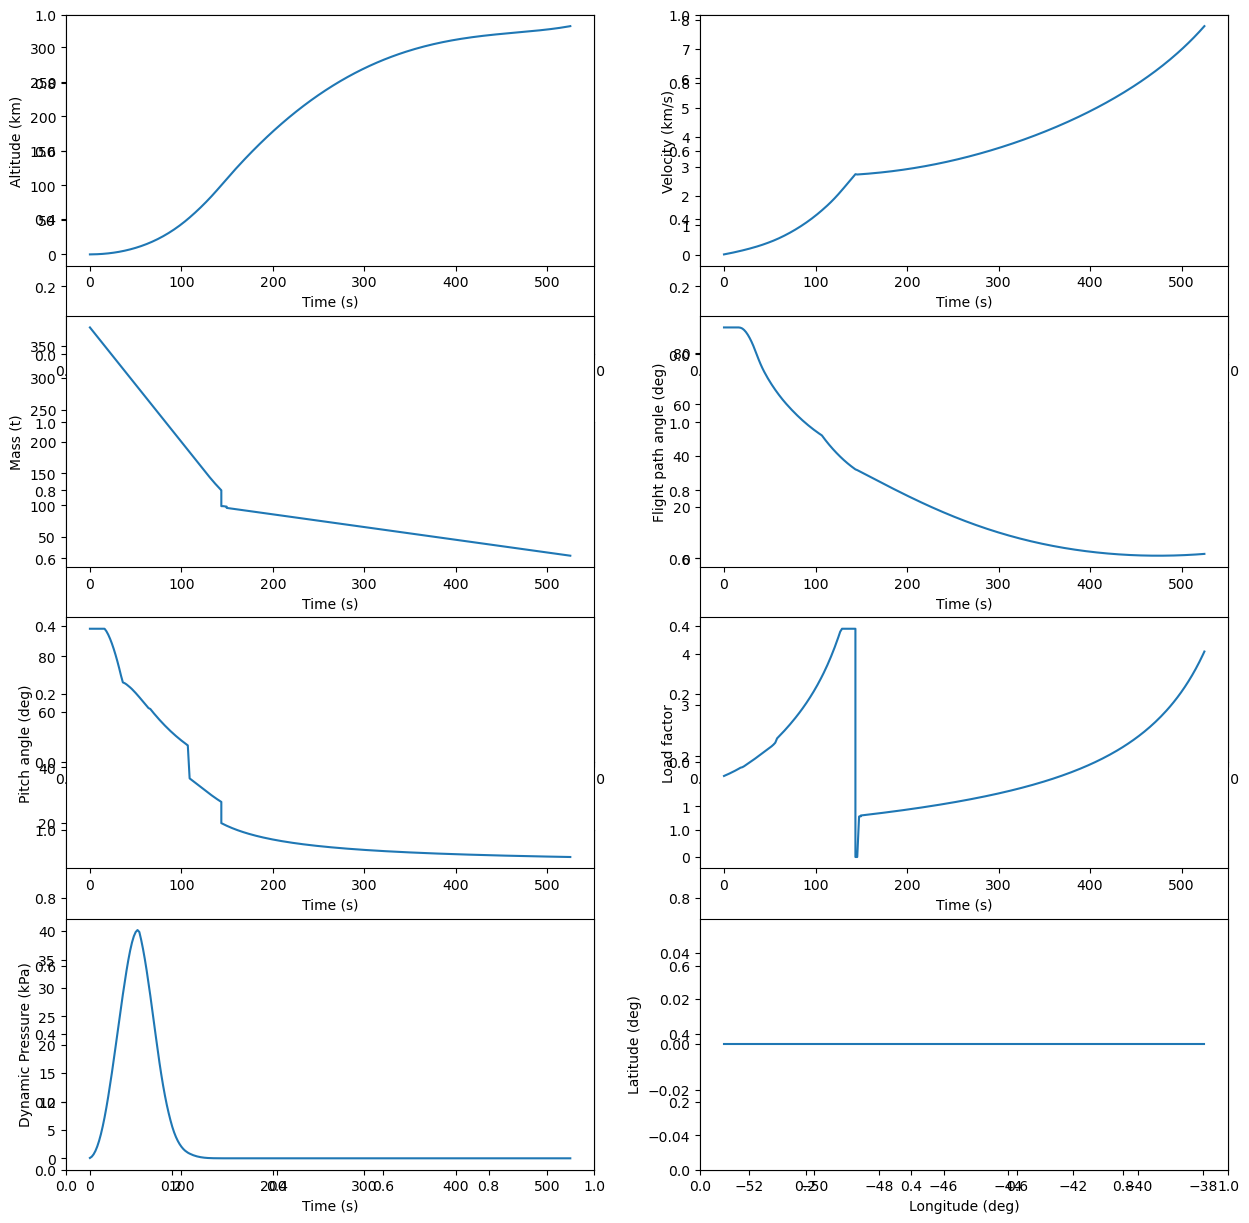

In [5]:
print("\n" + "="*80)
print("TESTING MATERIAL CONFIGURATIONS")
print("="*80)

# Create baseline problem
P_base = setup_baseline_problem()

# Test configurations
test_configs = {
    '100% Aluminum': [1.00, 1.00, 1.00, 1.00],
    '100% Composite': [0.62, 0.70, 0.80, 0.75],
    '50/50 Mix': [0.81, 0.85, 0.90, 0.875],
    'Optimized Mix': [0.70, 0.75, 0.85, 0.80],  # Educated guess
}

results = {}
for name, k_SM in test_configs.items():
    print(f"\nEvaluating: {name}")
    results[name] = evaluate_configuration(P_base, k_SM, verbose=True)

# Compare results
print("\n" + "="*80)
print("COMPARISON OF CONFIGURATIONS")
print("="*80)

df_compare = pd.DataFrame(results).T
print("\nLCA Scores:")
print(df_compare[['lca_score', 'lca_manufacturing', 'lca_benefit', 'mass_savings']].round(2))

result_vizualization.plots_output(P_base)

In [6]:
print("\n" + "="*80)
print("RUNNING CMA-ES OPTIMIZATION")
print("="*80)

def objective_function(x):
    """
    Objective function for CMA-ES
    x: normalized [0,1] array for k_SM values
    """

    from environment.Environmental_Discipline import Environmental_Discipline_Comp
    Environmental_Discipline_Comp._baseline_dry_mass = None

    # Convert normalized to actual k_SM
    k_SM_lower = np.array([0.62, 0.70, 0.80, 0.75])
    k_SM_upper = np.array([1.00, 1.00, 1.00, 1.00])
    k_SM = k_SM_lower + (k_SM_upper - k_SM_lower) * x
    
    # Create fresh problem (avoids state issues)
    P = setup_baseline_problem()
    
    # Evaluate
    result = evaluate_configuration(P, k_SM, verbose=False)
    
    # Check constraints
    penalty = 0
    if result['alt_final'] < 300:  # Must reach 300 km
        penalty += (300 - result['alt_final']) * 10
    if result['v_final'] < 7.5:  # Must reach 7.5 km/s
        penalty += (7.5 - result['v_final']) * 100
    if result['glow'] > 400000:  # GLOW limit 400 tonnes
        penalty += (result['glow'] - 400000) / 1000
    
    return result['lca_score'] + penalty

# CMA-ES settings
options = {
    'seed': 42,
    'maxiter': 150,
    'popsize': 8,
    'bounds': [[0]*4, [1]*4],
    'tolfun': 1e-3,
    'verb_disp': 1
}

# Initial guess (start with mixed materials)
x0 = np.array([0.3, 0.3, 0.5, 0.3])  # Favor some composite

print("\nOptimizing material composition...")
print("Variables: [k_SM_thrust_frame, k_SM_interstage, k_SM_intertank, k_SM_stage_2]")
print("Bounds:")
print("  Thrust frame: [0.62, 1.00] (0.62=composite, 1.00=aluminum)")
print("  Interstage:   [0.70, 1.00] (0.70=composite, 1.00=aluminum)")
print("  Intertank:    [0.80, 1.00] (0.80=composite, 1.00=aluminum)")
print("  Stage 2:      [0.75, 1.00] (0.75=composite, 1.00=aluminum)")
print("-"*80)

# Run optimization
res = cma.fmin(objective_function, x0, 0.2, options)


RUNNING CMA-ES OPTIMIZATION

Optimizing material composition...
Variables: [k_SM_thrust_frame, k_SM_interstage, k_SM_intertank, k_SM_stage_2]
Bounds:
  Thrust frame: [0.62, 1.00] (0.62=composite, 1.00=aluminum)
  Interstage:   [0.70, 1.00] (0.70=composite, 1.00=aluminum)
  Intertank:    [0.80, 1.00] (0.80=composite, 1.00=aluminum)
  Stage 2:      [0.75, 1.00] (0.75=composite, 1.00=aluminum)
--------------------------------------------------------------------------------
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=42, Sun Sep 28 16:28:46 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.693301818785428e+02 1.0e+00 2.07e-01  2e-01  2e-01 1:29.4
    2     16 2.634538625697015e+02 1.2e+00 2.55e-01  2e-01  3e-01 2:47.1
    3     24 2.581792101425671e+02 1.5e+00 3.34e-01  3e-01  4e-01 3:17.0
    4     32 2.552690156765448e+02 1.6e+00 3.90e-01  4e-01  5e-01 3:47.5
    5     40 2.619084359853036e+02 2.0e+00 3.57e-01  3e-01  4e-01 4:22.8
 


OPTIMIZATION RESULTS

Optimal k_SM values:
  Thrust frame: 1.000
  Interstage:   0.760
  Intertank:    1.000
  Stage 2:      1.000

Material composition (% Aluminum):
  Thrust frame: 100.0%
  Interstage:   19.9%
  Intertank:    100.0%
  Stage 2:      100.0%

--- Configuration Evaluation ---
k_SM values: [0.99999952 0.75966488 0.99999882 0.99999994]
LCA Score: 250.19 Pt
  Manufacturing: 250.19 Pt
  Operational benefit: -0.00 Pt
CO2 emissions: 845.2 tonnes
Material masses:
  Aluminum 7075: 9584.3 kg
  Aluminum Lithium: 12791.7 kg
  Composite: 18.3 kg
  Steel: 3144.6 kg
  Mass savings: 0.0 kg
GLOW: 381.48 tonnes
Performance: 312.2 km, 7.81 km/s

IMPROVEMENT SUMMARY
Baseline LCA score: 270.05 Pt
Optimal LCA score:  250.19 Pt
Improvement:        7.4%
CO2 reduction:      261.8 tonnes

--------------------------------------------------------------------------------
Generating trajectory plots...


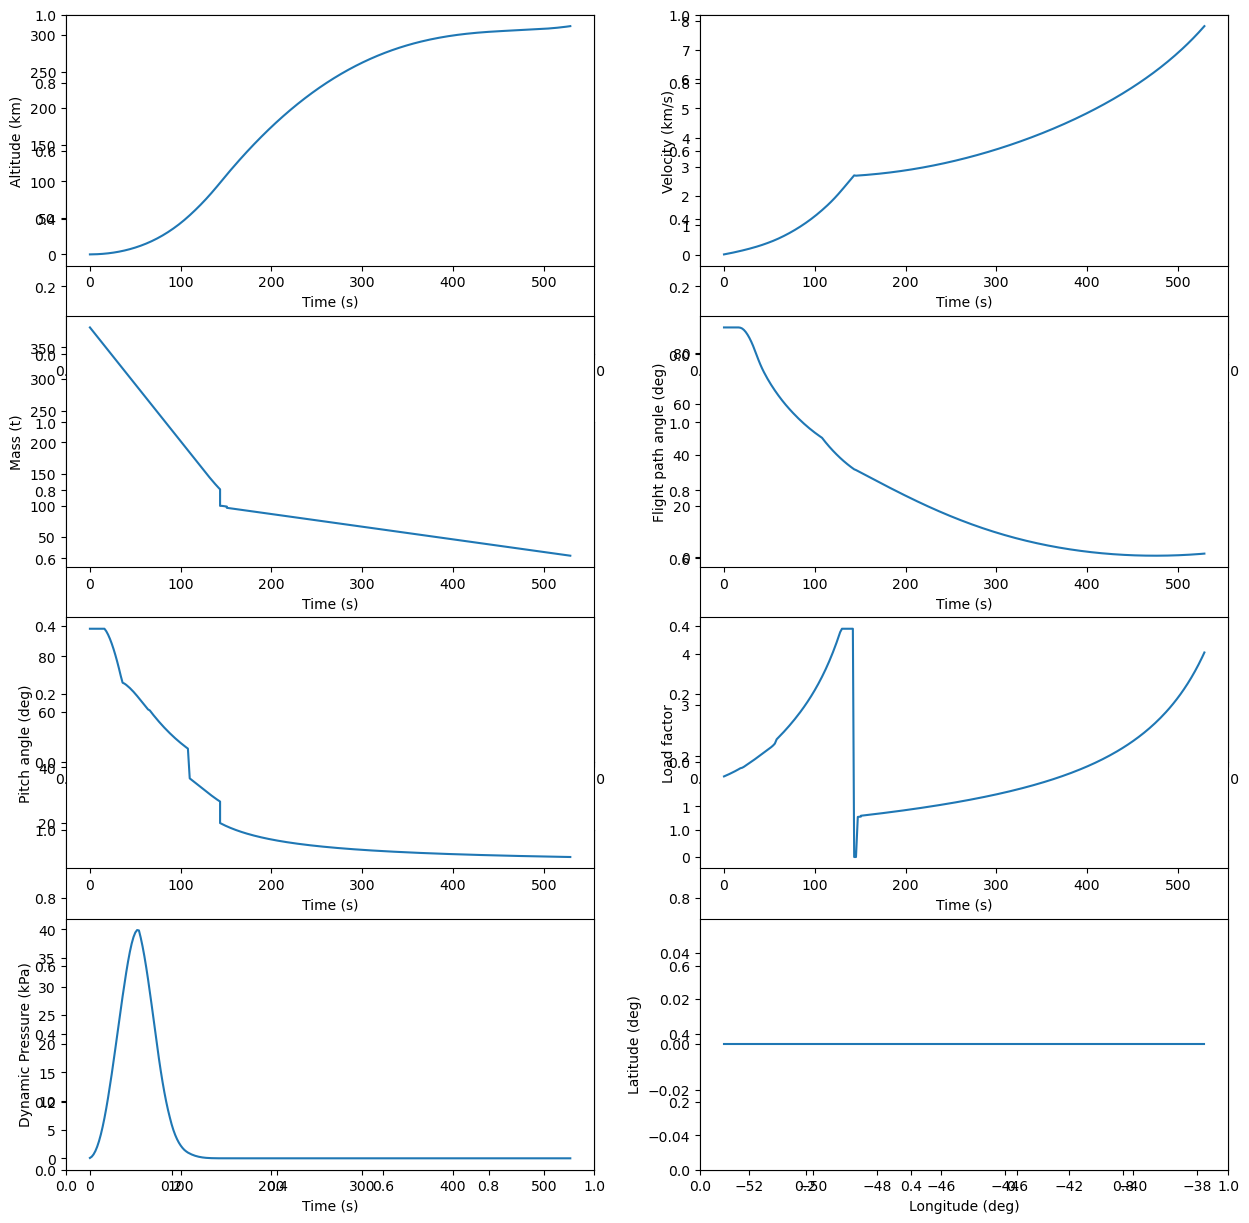


OPTIMIZATION COMPLETE


In [7]:
print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)

# Get optimal k_SM values
x_opt = res[0]
k_SM_lower = np.array([0.62, 0.70, 0.80, 0.75])
k_SM_upper = np.array([1.00, 1.00, 1.00, 1.00])
k_SM_optimal = k_SM_lower + (k_SM_upper - k_SM_lower) * x_opt

print(f"\nOptimal k_SM values:")
print(f"  Thrust frame: {k_SM_optimal[0]:.3f}")
print(f"  Interstage:   {k_SM_optimal[1]:.3f}")
print(f"  Intertank:    {k_SM_optimal[2]:.3f}")
print(f"  Stage 2:      {k_SM_optimal[3]:.3f}")

# Calculate material fractions
al_frac = [(k_SM_optimal[0]-0.62)/0.38, 
           (k_SM_optimal[1]-0.70)/0.30,
           (k_SM_optimal[2]-0.80)/0.20,
           (k_SM_optimal[3]-0.75)/0.25]

print(f"\nMaterial composition (% Aluminum):")
print(f"  Thrust frame: {al_frac[0]*100:.1f}%")
print(f"  Interstage:   {al_frac[1]*100:.1f}%")
print(f"  Intertank:    {al_frac[2]*100:.1f}%")
print(f"  Stage 2:      {al_frac[3]*100:.1f}%")

# Final evaluation
P_final = setup_baseline_problem()
result_optimal = evaluate_configuration(P_final, k_SM_optimal, verbose=True)

# Compare with baseline
baseline_result = results['50/50 Mix']
improvement = (baseline_result['lca_score'] - result_optimal['lca_score']) / baseline_result['lca_score'] * 100

print(f"\n" + "="*80)
print("IMPROVEMENT SUMMARY")
print("="*80)
print(f"Baseline LCA score: {baseline_result['lca_score']:.2f} Pt")
print(f"Optimal LCA score:  {result_optimal['lca_score']:.2f} Pt")
print(f"Improvement:        {improvement:.1f}%")
print(f"CO2 reduction:      {(baseline_result['co2_eq']-result_optimal['co2_eq'])/1000:.1f} tonnes")

# Generate trajectory plots
print("\n" + "-"*80)
print("Generating trajectory plots...")
result_vizualization.plots_output(P_final)

print("\n" + "="*80)
print("OPTIMIZATION COMPLETE")

In [8]:
print("\n" + "="*80)
print("DETAILED LCA ANALYSIS DEBUG")
print("="*80)

# Re-run the optimal configuration with verbose output
P_debug = setup_baseline_problem()
P_debug['k_SM_thrust_frame'] = k_SM_optimal[0]
P_debug['k_SM_interstage'] = k_SM_optimal[1]  
P_debug['k_SM_intertank'] = k_SM_optimal[2]
P_debug['k_SM_stage_2'] = k_SM_optimal[3]

# Run with verbose
P_debug.run_model()

# Extract detailed information
print("\n--- ECOINVENT ACTIVITIES BEING USED ---")
from environment.Environmental_Discipline import ECOINVENT_CODES
import brightway2 as bw

for material, (db_name, code) in ECOINVENT_CODES.items():
    try:
        activity = bw.get_activity((db_name, code))
        print(f"\n{material}:")
        print(f"  Name: {activity['name']}")
        print(f"  Unit: {activity['unit']}")
        print(f"  Location: {activity.get('location', 'GLO')}")
    except:
        print(f"\n{material}: NOT FOUND - Check the code!")

print("\n--- MATERIAL INVENTORY ---")
materials = {
    'aluminum_7075': P_debug['Environmental.total_aluminum_7075_kg'][0],
    'aluminum_lithium': P_debug['Environmental.total_aluminum_lithium_kg'][0],
    'cfrp': P_debug['Environmental.total_composite_kg'][0],
    'steel': P_debug['Environmental.total_steel_kg'][0],
    'titanium': P_debug['Environmental.total_titanium_kg'][0],
    'polyurethane_foam': P_debug['Environmental.total_insulation_kg'][0],
    'electronics': P_debug['Environmental.total_electronics_kg'][0],
}

print("\nStructural materials:")
for mat, mass in materials.items():
    if mass > 0:
        print(f"  {mat}: {mass:.1f} kg")

print(f"\nPropellants:")
print(f"  LOX: {P_debug['Environmental.Prop_mass_stage_1'][0] * (P_debug['OF_stage_1'][0]/(1+P_debug['OF_stage_1'][0])):.1f} kg")
print(f"  LH2: {P_debug['Environmental.Prop_mass_stage_1'][0] * (1/(1+P_debug['OF_stage_1'][0])):.1f} kg")

print("\n--- IMPACT ASSESSMENT BREAKDOWN ---")
for code in ['GWP', 'ADEPLf', 'ADEPLmu', 'FWTOX', 'PMAT']:
    impact = P_debug[f'Environmental.{code}_impact'][0]
    normalized = P_debug[f'Environmental.{code}_normalized'][0]
    weighted = P_debug[f'Environmental.{code}_weighted'][0]
    print(f"\n{code}:")
    print(f"  Raw impact: {impact:.3e}")
    print(f"  Normalized: {normalized:.4f}")
    print(f"  Weighted: {weighted:.4f} Pt")

print("\n--- OPERATIONAL BENEFIT ANALYSIS ---")
print(f"Mass savings: {P_debug['Environmental.mass_savings_kg'][0]:.1f} kg")
print(f"Implied fuel savings: {P_debug['Environmental.mass_savings_kg'][0] * 8:.1f} kg")
print(f"  - LH2: {P_debug['Environmental.mass_savings_kg'][0] * 8 * (1/(1+5.5)):.1f} kg")
print(f"  - LOX: {P_debug['Environmental.mass_savings_kg'][0] * 8 * (5.5/(1+5.5)):.1f} kg")
print(f"Operational benefit: {P_debug['Environmental.LCA_operational_benefit'][0]:.2f} Pt")

print("\n--- COMPONENT MATERIAL BREAKDOWN ---")
components = {
    'Thrust frame': (P_debug['Struct_1.M_thrust_frame'][0], 
                     P_debug['Struct_1.Al_fraction_thrust_frame'][0]),
    'Interstage': (P_debug['Struct_1.M_interstage'][0],
                   P_debug['Struct_1.Al_fraction_interstage'][0]),
    'Intertank': (P_debug['Struct_1.M_intertank'][0],
                  P_debug['Struct_1.Al_fraction_intertank'][0]),
}

for comp, (mass, al_frac) in components.items():
    print(f"\n{comp}:")
    print(f"  Total mass: {mass:.1f} kg")
    print(f"  Aluminum: {mass * al_frac:.1f} kg ({al_frac*100:.1f}%)")
    print(f"  Composite: {mass * (1-al_frac):.1f} kg ({(1-al_frac)*100:.1f}%)")

# Check if we're actually using Brightway or falling back
print("\n--- LCA METHOD ---")
try:
    import brightway2 as bw
    bw.projects.set_current("LCA_FELIN")
    if "ecoinvent 3.8 cutoff" in bw.databases:
        print("✓ Using Brightway2 with ecoinvent 3.8")
        
        # Test one material
        test_act = bw.get_activity(ECOINVENT_CODES['aluminum_7075'])
        test_lca = bw.LCA({test_act: 1}, ('EF v3.0', 'climate change', 'global warming potential (GWP100)'))
        test_lca.lci()
        test_lca.lcia()
        print(f"  Test: 1 kg aluminum_7075 = {test_lca.score:.2f} kg CO2-eq")
        
        test_act2 = bw.get_activity(ECOINVENT_CODES['cfrp'])
        test_lca2 = bw.LCA({test_act2: 1}, ('EF v3.0', 'climate change', 'global warming potential (GWP100)'))
        test_lca2.lci()
        test_lca2.lcia()
        print(f"  Test: 1 kg CFRP = {test_lca2.score:.2f} kg CO2-eq")
    else:
        print("✗ Ecoinvent database not found - using simplified factors")
except:
    print("✗ Brightway2 not available - using simplified factors")


DETAILED LCA ANALYSIS DEBUG

--- ECOINVENT ACTIVITIES BEING USED ---

aluminum_7075:
  Name: market for aluminium, wrought alloy
  Unit: kilogram
  Location: GLO

aluminum_lithium:
  Name: market for aluminium alloy, AlLi
  Unit: kilogram
  Location: GLO

cfrp:
  Name: market for carbon fibre reinforced plastic, injection moulded
  Unit: kilogram
  Location: GLO

steel:
  Name: market for steel, low-alloyed, hot rolled
  Unit: kilogram
  Location: GLO

titanium:
  Name: market for titanium, triple-melt
  Unit: kilogram
  Location: GLO

polyurethane_foam:
  Name: market for polyurethane, rigid foam
  Unit: kilogram
  Location: RER

electronics:
  Name: market for electronic component, passive, unspecified
  Unit: kilogram
  Location: GLO

lox:
  Name: market for oxygen, liquid
  Unit: kilogram
  Location: RER

lh2:
  Name: market for hydrogen, liquid
  Unit: kilogram
  Location: RER

transport_ship:
  Name: transport, freight, sea, container ship with reefer, cooling
  Unit: ton kilome

In [2]:
# Create an OpenMDAO problem using the launch vehicle group with LCA
P_obj = om.Problem()
P_obj.model = Launch_vehicle_Group.Launcher_vehicle()
P_obj.setup()

In [3]:
# Fixed Point Iteration for single evaluation
def FPI(Pb):
    """
    Fixed Point Iteration for solving the coupled system
    """
    Pb.setup(check=False)

    # Define bounds for design variables including material compositions
    lowerbnd_exp = np.array([
        150.,   # Prop_mass_stage_1 (tonnes)
        20.,    # Prop_mass_stage_2 (tonnes)
        0.,     # theta_cmd_i
        -10.,   # theta_cmd_f
        -1.,    # ksi
        5.,     # Pitch_over_duration
        5.,     # Delta_vertical_phase
        1.,     # Delta_theta_pitch_over
        10., 10.,  # command_stage_1_exo (2 values)
    ])

    upperbnd_exp = np.array([
        600.,   # Prop_mass_stage_1 (tonnes)
        200.,   # Prop_mass_stage_2 (tonnes)
        50.,    # theta_cmd_i
        20.,    # theta_cmd_f
        1.,     # ksi
        20.,    # Pitch_over_duration
        20.,    # Delta_vertical_phase
        10.,    # Delta_theta_pitch_over
        70., 70.,  # command_stage_1_exo (2 values)
    ])

    # Optimal normalized values from CMA-ES
    x_optimal = np.array([0.23527546, 0.36153667, 0.39784285, 0.53903249, 
                          0.22424615, 0.96230176, 0.75167229, 0.8693451, 
                          0.44461484, 0.17382506])

    # Convert normalized to actual values
    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp) * x_optimal
    
    # Set default values
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 300.
    Pb['Mass_flow_rate_stage_2'] = 200.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 1000.
    Pb['OF_stage_1'] = 5.0
    Pb['OF_stage_2'] = 5.5
    Pb['Pc_stage_1'] = 80.
    Pb['Pc_stage_2'] = 60.
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 6.
    Pb['N_eng_stage_2'] = 1.
    Pb['Prop_mass_stage_1'] = XX[0] * 1e3 
    Pb['Prop_mass_stage_2'] = XX[1] * 1e3 
    Pb['thetacmd_i'] = XX[2]
    Pb['thetacmd_f'] = XX[3]
    Pb['ksi'] = XX[4]
    Pb['Pitch_over_duration'] = XX[5]
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['Delta_vertical_phase'] = XX[6]
    Pb['Delta_theta_pitch_over'] = XX[7]
    Pb['command_stage_1_exo'] = XX[8:10] 
    Pb['is_fallout'] = 0.
    
    # NEW: Set default material compositions (50/50 mix)
    Pb['k_SM_thrust_frame'] = 0.81  # 50% Al, 50% Composite for thrust frame
    Pb['k_SM_interstage'] = 0.85    # 50% Al, 50% Composite for interstage
    Pb['k_SM_intertank'] = 0.9      # 50% Al, 50% Composite for intertank

    # Fixed point iteration
    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k = 0

    print("\nRunning FPI with exact optimized FELIN baseline...")
    print(f"Prop_mass_stage_1: {XX[0]*1e3:.1f} kg")
    print(f"Prop_mass_stage_2: {XX[1]*1e3:.1f} kg")
    print(f"Trajectory params: theta_i={XX[2]:.1f}°, theta_f={XX[3]:.1f}°, ksi={XX[4]:.3f}")
    print(f"Command exo: [{XX[8]:.1f}, {XX[9]:.1f}]")

    while error > 1. and k < 20:
        Pb.run_model()
        # Replace the two lines that use 'max_pdyn_load_ascent_stage_1'
        qmax = np.max(Pb.get_val('pdyn_ascent'))
        error = abs(Pb.get_val('Pdyn_max_dim') - qmax/1e3)  # kPa target vs Pa series
        Pb.set_val('Pdyn_max_dim', qmax/1e3)

        #error = abs(Pb['Pdyn_max_dim'] - Pb['max_pdyn_load_ascent_stage_1']/1e3)
        #Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k + 1
        if k <= 3 or k % 5 == 0:
            print(f'Fixed Point Iteration: {k}, error: {np.round(error[0],2)}, '
              f'Input pdyn max (kPa): {np.round(Pb["Pdyn_max_dim"][0],2)}')
            
    print(f"  Converged after {k} iterations")
    
    # Verify we get the expected masses
    print("\nAchieved configuration:")
    print(f"  GLOW: {Pb['GLOW'][0]/1000:.2f} tonnes (target: 381.46)")
    print(f"  Dry_mass_stage_1: {Pb['Dry_mass_stage_1'][0]/1000:.2f} tonnes")
    print(f"  Dry_mass_stage_2: {Pb['Dry_mass_stage_2'][0]/1000:.2f} tonnes")
    
    # Check trajectory performance
    nb_pts = int(Pb['Nb_pt_ascent'][0])
    alt_final = Pb['alt_ascent'][nb_pts-1] / 1000.0
    v_final = Pb['V_ascent'][nb_pts-1] / 1000.0
    print(f"\nTrajectory performance:")
    print(f"  Final altitude: {alt_final:.1f} km")
    print(f"  Final velocity: {v_final:.2f} km/s")

    return Pb



RUNNING FIXED POINT ITERATION

Running FPI with exact optimized FELIN baseline...
Prop_mass_stage_1: 255874.0 kg
Prop_mass_stage_2: 85076.6 kg
Trajectory params: theta_i=19.9°, theta_f=6.2°, ksi=-0.552
Command exo: [36.7, 20.4]
Fixed Point Iteration: 1, error: 1612.49, Input pdyn max (kPa): 1652.49
Fixed Point Iteration: 2, error: 1612.86, Input pdyn max (kPa): 39.63
Fixed Point Iteration: 3, error: 1612.93, Input pdyn max (kPa): 1652.56
Fixed Point Iteration: 5, error: 1612.93, Input pdyn max (kPa): 1652.56
  Converged after 7 iterations

Achieved configuration:
  GLOW: 380.69 tonnes (target: 381.46)
  Dry_mass_stage_1: 25.36 tonnes
  Dry_mass_stage_2: 7.38 tonnes

Trajectory performance:
  Final altitude: 318.1 km
  Final velocity: 7.80 km/s
✓ FPI Complete


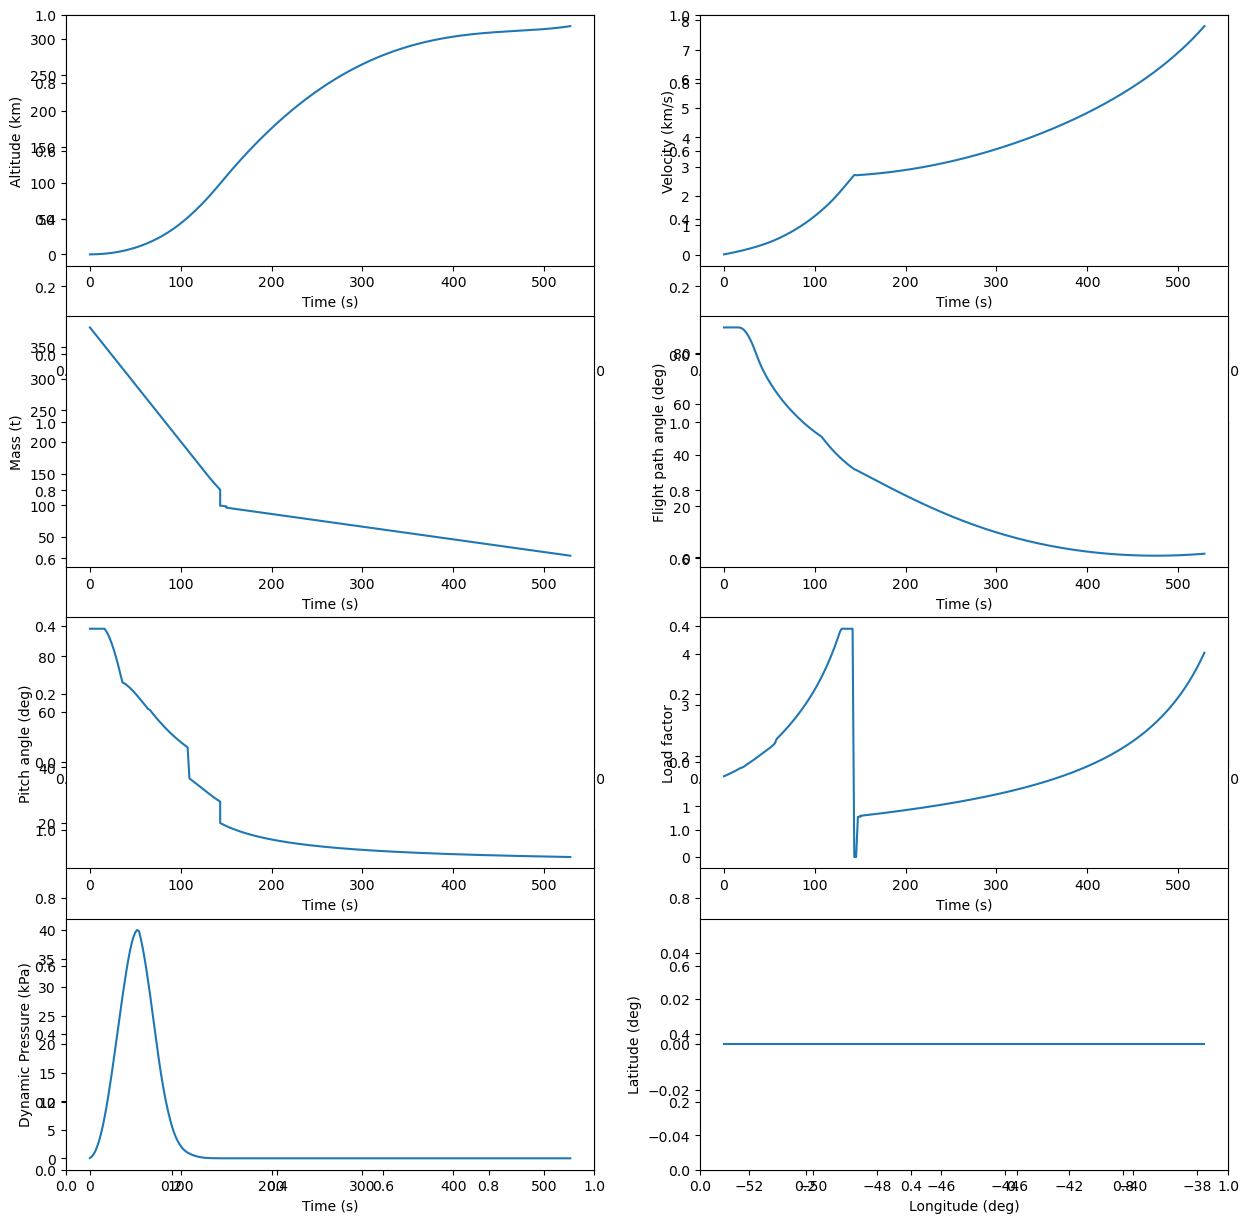

In [4]:
# Run Fixed Point Iteration
print("\n" + "="*60)
print("RUNNING FIXED POINT ITERATION")
print("="*60)
P_out = FPI(P_obj)
print("✓ FPI Complete")

result_vizualization.plots_output(P_out)


In [5]:
# ============================================================
# DEFINE FPI FOR LCA OPTIMIZATION
# ============================================================

def FPI_LCA_optim(x, Pb):
    """
    Fixed Point Iteration for LCA optimization
    x: normalized [0,1] array of k_SM values
    """
    Pb.setup(check=False)
    
    # Define bounds for k_SM parameters
    k_SM_lower = np.array([
        0.62,  # k_SM_thrust_frame minimum (100% Composite)
        0.70,  # k_SM_interstage minimum (100% Composite)
        0.80,  # k_SM_intertank minimum (100% Composite)
    ])
    
    k_SM_upper = np.array([
        1.00,  # k_SM_thrust_frame maximum (100% Al)
        1.00,  # k_SM_interstage maximum (100% Al)
        1.00,  # k_SM_intertank maximum (100% Al)
    ])
    
    # Convert normalized to actual k_SM values
    k_SM_actual = k_SM_lower + (k_SM_upper - k_SM_lower) * x
    
    # FIXED OPTIMAL TRAJECTORY PARAMETERS
    # These come from your CMA-ES optimization
    lowerbnd_traj = np.array([150., 20., 0., -10., -1., 5., 5., 1., 10., 10.])
    upperbnd_traj = np.array([600., 200., 50., 20., 1., 20., 20., 10., 70., 70.])
    x_optimal_traj = np.array([0.23527546, 0.36153667, 0.39784285, 0.53903249, 
                               0.22424615, 0.96230176, 0.75167229, 0.8693451, 
                               0.44461484, 0.17382506])
    XX = lowerbnd_traj + (upperbnd_traj - lowerbnd_traj) * x_optimal_traj
    
    # Set all fixed parameters
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 300.
    Pb['Mass_flow_rate_stage_2'] = 200.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 1000.
    Pb['OF_stage_1'] = 5.0
    Pb['OF_stage_2'] = 5.5
    Pb['Pc_stage_1'] = 80.
    Pb['Pc_stage_2'] = 60.
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 6.
    Pb['N_eng_stage_2'] = 1.
    
    # Fixed optimal trajectory parameters
    Pb['Prop_mass_stage_1'] = XX[0] * 1e3
    Pb['Prop_mass_stage_2'] = XX[1] * 1e3
    Pb['thetacmd_i'] = XX[2]
    Pb['thetacmd_f'] = XX[3]
    Pb['ksi'] = XX[4]
    Pb['Pitch_over_duration'] = XX[5]
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['Delta_vertical_phase'] = XX[6]
    Pb['Delta_theta_pitch_over'] = XX[7]
    Pb['command_stage_1_exo'] = XX[8:10]
    Pb['is_fallout'] = 0.
    
    # VARIABLE MATERIAL PARAMETERS (what we're optimizing)
    Pb['k_SM_thrust_frame'] = k_SM_actual[0]
    Pb['k_SM_interstage'] = k_SM_actual[1]
    Pb['k_SM_intertank'] = k_SM_actual[2]
    
    # Fixed point iteration for Pdyn convergence
    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k = 0
    
    while error > 1. and k < 20:
        Pb.run_model()
        qmax = np.max(Pb.get_val('pdyn_ascent'))
        error = abs(Pb.get_val('Pdyn_max_dim') - qmax/1e3)
        Pb.set_val('Pdyn_max_dim', qmax/1e3)
        k = k + 1
    
    return Pb

In [6]:
# ============================================================
# DEFINE OBJECTIVE FUNCTION FOR LCA
# ============================================================

def LCA_objective_function(x, Pb, verbose=False):
    """
    Objective function for LCA optimization
    Minimizes Environmental.LCA_score (ESA single score in Points)
    """
    # Run FPI with current material composition
    P_out = FPI_LCA_optim(x, Pb)
    
    # Get LCA score
    lca_score = P_out['Environmental.LCA_score'][0]
    
    # Get trajectory performance for constraint checking
    nb_pts = int(P_out['Nb_pt_ascent'][0])
    alt_final = P_out['alt_ascent'][nb_pts-1] / 1000.0  # km
    v_final = P_out['V_ascent'][nb_pts-1] / 1000.0     # km/s
    
    # Check constraints (trajectory must remain viable)
    constraints = []
    
    # Altitude constraint: must reach at least 300 km
    alt_constraint = max(0, 300 - alt_final) / 100  # normalized
    constraints.append(alt_constraint)
    
    # Velocity constraint: must reach at least 7.5 km/s
    vel_constraint = max(0, 7.5 - v_final)  # normalized
    constraints.append(vel_constraint)
    
    # Mass constraint: GLOW should not exceed original by more than 5%
    glow = P_out['GLOW'][0] / 1000.0  # tonnes
    glow_constraint = max(0, glow - 400.0) / 100  # normalized
    constraints.append(glow_constraint)
    
    if verbose:
        # Get material fractions for display
        k_SM_thrust = P_out['k_SM_thrust_frame'][0]
        k_SM_inter = P_out['k_SM_interstage'][0]
        k_SM_tank = P_out['k_SM_intertank'][0]
        
        print(f"\nk_SM: [{k_SM_thrust:.3f}, {k_SM_inter:.3f}, {k_SM_tank:.3f}]")
        print(f"LCA Score: {lca_score:.2f} Pt")
        print(f"GLOW: {glow:.1f} t, Alt: {alt_final:.1f} km, Vel: {v_final:.2f} km/s")
        print(f"Constraints: {constraints}")
    
    # Apply penalty if constraints violated
    total_constraint_violation = sum(constraints)
    if total_constraint_violation > 1e-3:
        # Return penalized objective (large value)
        return 1000.0 + total_constraint_violation * 100
    else:
        # Return LCA score to minimize
        return lca_score

In [10]:
# ============================================================
# RUN OPTIMIZATION
# ============================================================

print("\n" + "="*80)
print("LCA MATERIAL OPTIMIZATION FOR FELIN LAUNCHER")
print("="*80)

# Create problem instance
P_opt = om.Problem()
P_opt.model = Launch_vehicle_Group.Launcher_vehicle()

# Define CMA-ES options
options = {
    'ftarget': 100,      # Target LCA score (optimistic)
    'tolfun': 1e-3,      # Function tolerance
    'tolx': 1e-4,        # Variable tolerance  
    'seed': 42,          # Random seed
    'bounds': [[0]*3, [1]*3],  # Normalized bounds
    'popsize': 8,        # Population size (small for 3 variables)
    'maxiter': 150,       # Maximum iterations
    'verb_disp': 1       # Verbose display
}

# Initial guess (start with baseline 50/50 mix)
# k_SM values: thrust_frame=0.81, interstage=0.85, intertank=0.9
# Normalized: [(0.81-0.62)/0.38, (0.85-0.70)/0.30, (0.90-0.80)/0.20]
x0 = np.array([0.5, 0.5, 0.5])  # Start at 50% between bounds

# Define objective for CMA
objective_cma = lambda x: LCA_objective_function(x, P_opt, verbose=False)

print("\nOptimizing material composition to minimize LCA score...")
print("Design variables:")
print("  k_SM_thrust_frame: [0.62, 1.00] (0.62=100% Composite, 1.00=100% Al)")
print("  k_SM_interstage:   [0.70, 1.00] (0.70=100% Composite, 1.00=100% Al)")
print("  k_SM_intertank:    [0.80, 1.00] (0.80=100% Composite, 1.00=100% Al)")
print("\nBaseline LCA score: ~269 Pt")
print("-"*80)

# Run optimization
res = cma.fmin(objective_cma, x0, 0.2, options)


LCA MATERIAL OPTIMIZATION FOR FELIN LAUNCHER

Optimizing material composition to minimize LCA score...
Design variables:
  k_SM_thrust_frame: [0.62, 1.00] (0.62=100% Composite, 1.00=100% Al)
  k_SM_interstage:   [0.70, 1.00] (0.70=100% Composite, 1.00=100% Al)
  k_SM_intertank:    [0.80, 1.00] (0.80=100% Composite, 1.00=100% Al)

Baseline LCA score: ~269 Pt
--------------------------------------------------------------------------------
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 3 (seed=42, Thu Sep 25 20:09:14 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.655854382242225e+02 1.0e+00 1.89e-01  2e-01  2e-01 0:41.9
    2     16 2.679541544481031e+02 1.2e+00 1.62e-01  1e-01  2e-01 2:02.4
    3     24 2.656869988344374e+02 1.3e+00 1.54e-01  1e-01  2e-01 2:43.2
    4     32 2.652288366412756e+02 1.4e+00 1.74e-01  1e-01  2e-01 3:13.9
    5     40 2.618954624738263e+02 1.3e+00 2.29e-01  2e-01  2e-01 3:43.5
    6     48 2.606245385878233e+02 


OPTIMIZATION RESULTS

Optimal material composition:
  k_SM_thrust_frame: 0.997
  k_SM_interstage:   0.923
  k_SM_intertank:    0.999

Material mix:
  Thrust frame: 99.3% Al, 0.7% Composite
  Interstage:   74.4% Al, 25.6% Composite
  Intertank:    99.7% Al, 0.3% Composite

--------------------------------------------------------------------------------
Final evaluation with optimal design:

Final performance:
  LCA Score:     258.74 Pt (baseline: 269 Pt)
  CO2 emissions: 942.7 tonnes
  GLOW:          381.5 tonnes
  Final altitude: 312.5 km
  Final velocity: 7.81 km/s

LCA improvement: 3.8%

SENSITIVITY ANALYSIS
    Configuration  LCA Score (Pt)  GLOW (t)
0   100% Aluminum          258.60    381.46
1  100% Composite          275.52    379.94
2       50/50 Mix          269.37    380.69
3         Optimal          258.74    381.45

--------------------------------------------------------------------------------
Generating plots for optimal design...


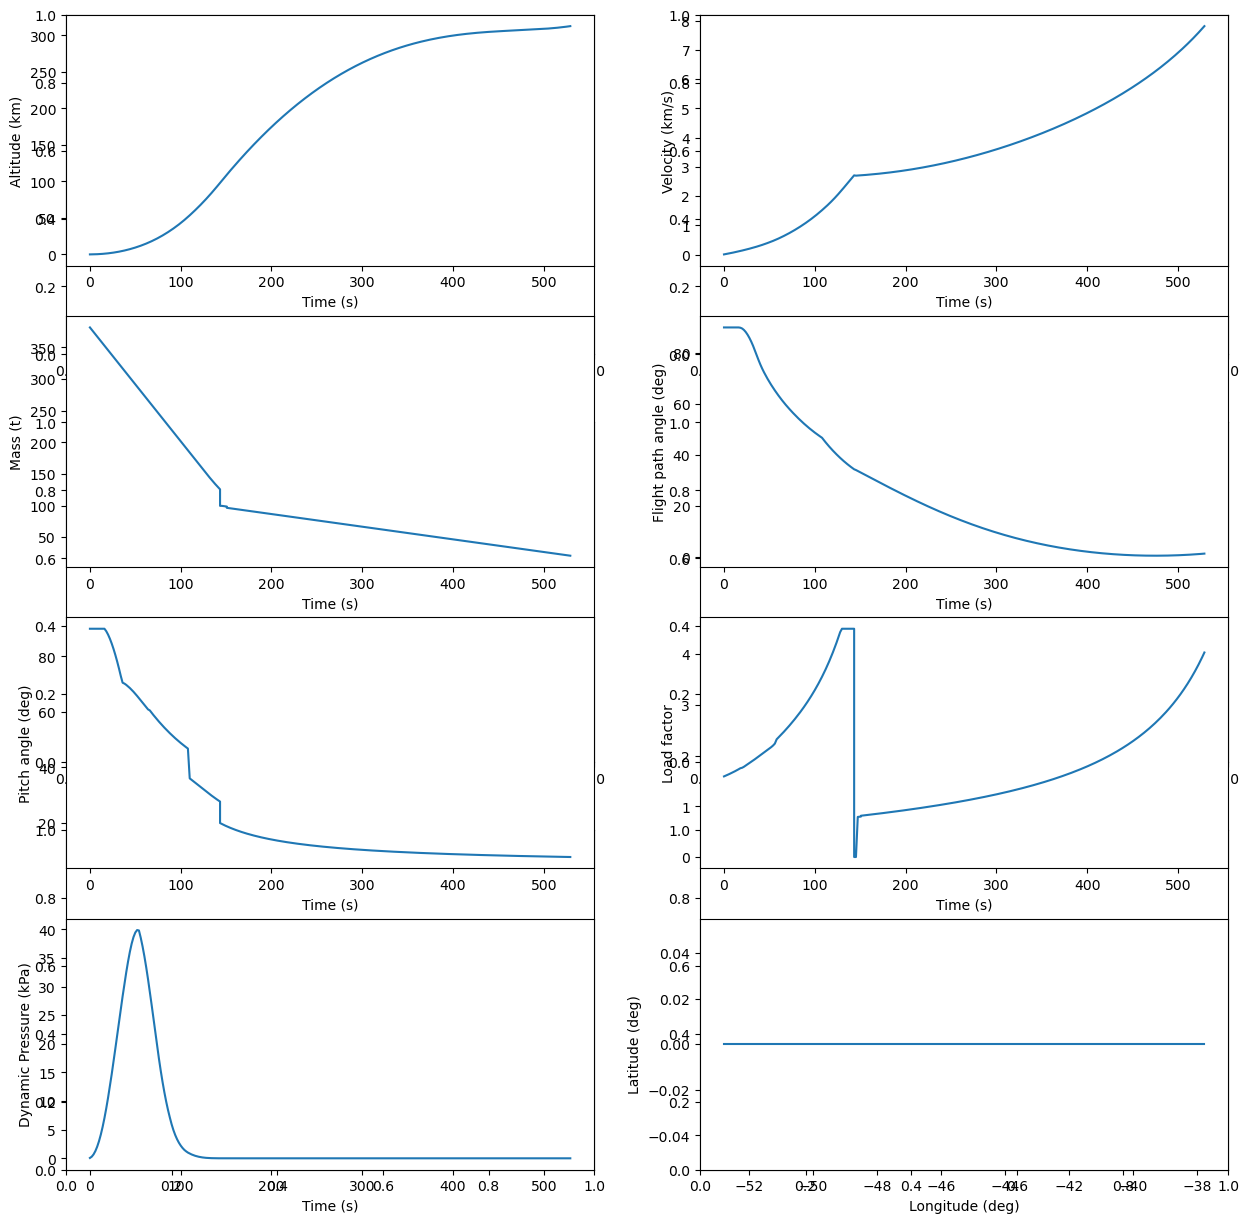


OPTIMIZATION COMPLETE


In [11]:
# ============================================================
# ANALYZE RESULTS
# ============================================================

print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)

# Get optimal design
x_opt = res[0]

# Convert to actual k_SM values
k_SM_lower = np.array([0.62, 0.70, 0.80])
k_SM_upper = np.array([1.00, 1.00, 1.00])
k_SM_optimal = k_SM_lower + (k_SM_upper - k_SM_lower) * x_opt

print(f"\nOptimal material composition:")
print(f"  k_SM_thrust_frame: {k_SM_optimal[0]:.3f}")
print(f"  k_SM_interstage:   {k_SM_optimal[1]:.3f}")
print(f"  k_SM_intertank:    {k_SM_optimal[2]:.3f}")

# Calculate material fractions
al_frac_thrust = (k_SM_optimal[0] - 0.62) / 0.38
comp_frac_thrust = 1.0 - al_frac_thrust

al_frac_inter = (k_SM_optimal[1] - 0.70) / 0.30
comp_frac_inter = 1.0 - al_frac_inter

al_frac_tank = (k_SM_optimal[2] - 0.80) / 0.20
comp_frac_tank = 1.0 - al_frac_tank

print(f"\nMaterial mix:")
print(f"  Thrust frame: {al_frac_thrust*100:.1f}% Al, {comp_frac_thrust*100:.1f}% Composite")
print(f"  Interstage:   {al_frac_inter*100:.1f}% Al, {comp_frac_inter*100:.1f}% Composite")
print(f"  Intertank:    {al_frac_tank*100:.1f}% Al, {comp_frac_tank*100:.1f}% Composite")

# Run final evaluation with optimal design
print("\n" + "-"*80)
print("Final evaluation with optimal design:")
P_final = FPI_LCA_optim(x_opt, P_opt)

# Get final results
lca_final = P_final['Environmental.LCA_score'][0]
co2_final = P_final['Environmental.CO2_eq'][0] / 1000.0  # tonnes
glow_final = P_final['GLOW'][0] / 1000.0  # tonnes
nb_pts = int(P_final['Nb_pt_ascent'][0])
alt_final = P_final['alt_ascent'][nb_pts-1] / 1000.0
v_final = P_final['V_ascent'][nb_pts-1] / 1000.0

print(f"\nFinal performance:")
print(f"  LCA Score:     {lca_final:.2f} Pt (baseline: 269 Pt)")
print(f"  CO2 emissions: {co2_final:.1f} tonnes")
print(f"  GLOW:          {glow_final:.1f} tonnes")
print(f"  Final altitude: {alt_final:.1f} km")
print(f"  Final velocity: {v_final:.2f} km/s")

# Calculate improvement
improvement = (269 - lca_final) / 269 * 100
print(f"\nLCA improvement: {improvement:.1f}%")

# ============================================================
# SENSITIVITY ANALYSIS (OPTIONAL)
# ============================================================

print("\n" + "="*80)
print("SENSITIVITY ANALYSIS")
print("="*80)

# Test corner cases
test_cases = [
    ([1.0, 1.0, 1.0], "100% Aluminum"),
    ([0.0, 0.0, 0.0], "100% Composite"),
    ([0.5, 0.5, 0.5], "50/50 Mix"),
    (x_opt, "Optimal")
]

results = []
for x_test, label in test_cases:
    P_test = FPI_LCA_optim(x_test, P_opt)
    lca = P_test['Environmental.LCA_score'][0]
    glow = P_test['GLOW'][0] / 1000.0
    results.append([label, lca, glow])

df_sensitivity = pd.DataFrame(results, columns=['Configuration', 'LCA Score (Pt)', 'GLOW (t)'])
print(df_sensitivity.round(2))

# ============================================================
# PLOT RESULTS
# ============================================================

# Generate trajectory plots for optimal design
print("\n" + "-"*80)
print("Generating plots for optimal design...")
result_vizualization.plots_output(P_final)

print("\n" + "="*80)
print("OPTIMIZATION COMPLETE")
print("="*80)

In [ ]:
# FPI for optimization with material variables
def FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb):
    """
    Fixed Point Iteration for optimization including material composition variables
    """
    Pb.setup(check=False)
    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp)*x
    
    # Fixed parameters
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.0
    Pb['Mass_flow_rate_stage_1'] = 300.
    Pb['Mass_flow_rate_stage_2'] = 200.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 1000.
    Pb['OF_stage_1'] = 5.
    Pb['OF_stage_2'] = 5.5
    Pb['Pc_stage_1'] = 80.0
    Pb['Pc_stage_2'] = 60.0
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 6.
    Pb['N_eng_stage_2'] = 1.
    
    # Design variables from optimization
    Pb['Prop_mass_stage_1'] = 255
    Pb['Prop_mass_stage_2'] = 85
    Pb['thetacmd_i'] = XX[2]
    Pb['thetacmd_f'] = XX[3] 
    Pb['ksi'] = XX[4]
    Pb['Pitch_over_duration'] = XX[5]
    Pb['Delta_vertical_phase'] = XX[6]
    Pb['Delta_theta_pitch_over'] = XX[7]        
    Pb['command_stage_1_exo'] = XX[8:10]
    
    # NEW: Material composition design variables
    Pb['k_SM_thrust_frame'] = XX[10]
    Pb['k_SM_interstage'] = XX[11]
    
    # Fixed parameters
    Pb['Exit_nozzle_area_stage_1'] = 0.79
    Pb['Exit_nozzle_area_stage_2'] = 3.6305
    Pb['is_fallout'] = 0.

    # Fixed point iteration
    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k = 0
    while error > 1. and k < 20:
        Pb.run_model()
        error = abs(Pb['Pdyn_max_dim'] - Pb['max_pdyn_load_ascent_stage_1']/1e3)
        Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k + 1
    return Pb

In [5]:
# Environmental Objective Function
def Objective_function_LCA(x, lowerbnd_exp, upperbnd_exp, Pb, simu):
    """
    Objective function for environmental optimization
    Minimizes LCA score while respecting all trajectory constraints
    """
    P_out = FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb)
    GLOW, contraintes = post_traitement.post_traitement(P_out)
    LCA_score = P_out['Environmental.LCA_score'][0]
    
    if simu == 0:  # Optimization mode
        if len(np.where(contraintes > 1e-2)[0]) == 0:
            # All constraints satisfied - minimize LCA score
            # Scale LCA score for optimizer (assuming typical values 1e5-1e6)
            return LCA_score / 1e5
        else:
            # Constraints not satisfied - minimize constraint violation
            cont = np.sum(contraintes[np.where(contraintes > 0)[0]])
            return 1000 + cont  # Large penalty for constraint violations
    else:  # Evaluation mode
        if len(np.where(contraintes > 1e-2)[0]) == 0:
            return LCA_score, GLOW, -5  # Return both LCA and GLOW for analysis
        else:
            return LCA_score, GLOW, contraintes

In [6]:
# Multi-objective function (optional - for Pareto front analysis)
def Objective_function_multiobjective(x, lowerbnd_exp, upperbnd_exp, Pb, w_lca=0.7, w_glow=0.3):
    """
    Multi-objective function balancing LCA and GLOW
    w_lca: weight for LCA score (default 0.7)
    w_glow: weight for GLOW (default 0.3)
    """
    P_out = FPI_optim(x, lowerbnd_exp, upperbnd_exp, Pb)
    GLOW, contraintes = post_traitement.post_traitement(P_out)
    LCA_score = P_out['Environmental.LCA_score'][0]
    
    if len(np.where(contraintes > 1e-2)[0]) == 0:
        # Normalize objectives (typical ranges)
        LCA_norm = LCA_score / 1e6  # Assuming LCA ~1e6
        GLOW_norm = GLOW / 5e5      # Assuming GLOW ~500 tonnes
        
        # Weighted sum
        obj = w_lca * LCA_norm + w_glow * GLOW_norm
        return obj
    else:
        # Constraints not satisfied
        cont = np.sum(contraintes[np.where(contraintes > 0)[0]])
        return 1000 + cont


OPTIMIZATION SETUP
Optimizing for minimum LCA score

Starting CMA-ES optimization...
Number of design variables: 12
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=2, Sun Sep 21 14:55:50 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.009183060437573e+03 1.0e+00 2.04e-01  2e-01  2e-01 2:13.6
    2     32 8.003241047502306e+03 1.2e+00 1.86e-01  2e-01  2e-01 4:11.0
    3     48 1.009731546013860e+03 1.3e+00 1.87e-01  2e-01  2e-01 5:55.1
    4     64 1.075919802538128e+03 1.3e+00 1.96e-01  2e-01  2e-01 7:57.5
    5     80 1.022323393950461e+03 1.4e+00 2.03e-01  2e-01  2e-01 9:54.8
    6     96 1.009045174208175e+03 1.5e+00 2.06e-01  2e-01  2e-01 11:34.3
    7    112 1.029572041855404e+03 1.6e+00 2.05e-01  2e-01  2e-01 13:13.5
    8    128 1.051430950017795e+03 1.7e+00 2.02e-01  2e-01  2e-01 15:14.3
    9    144 1.015365524776739e+03 1.7e+00 1.99e-01  2e-01  2e-01 16:48.4
   10    160 1.031674142703415e+03 1.7e+00 1.92e-01  2e-01  2e-

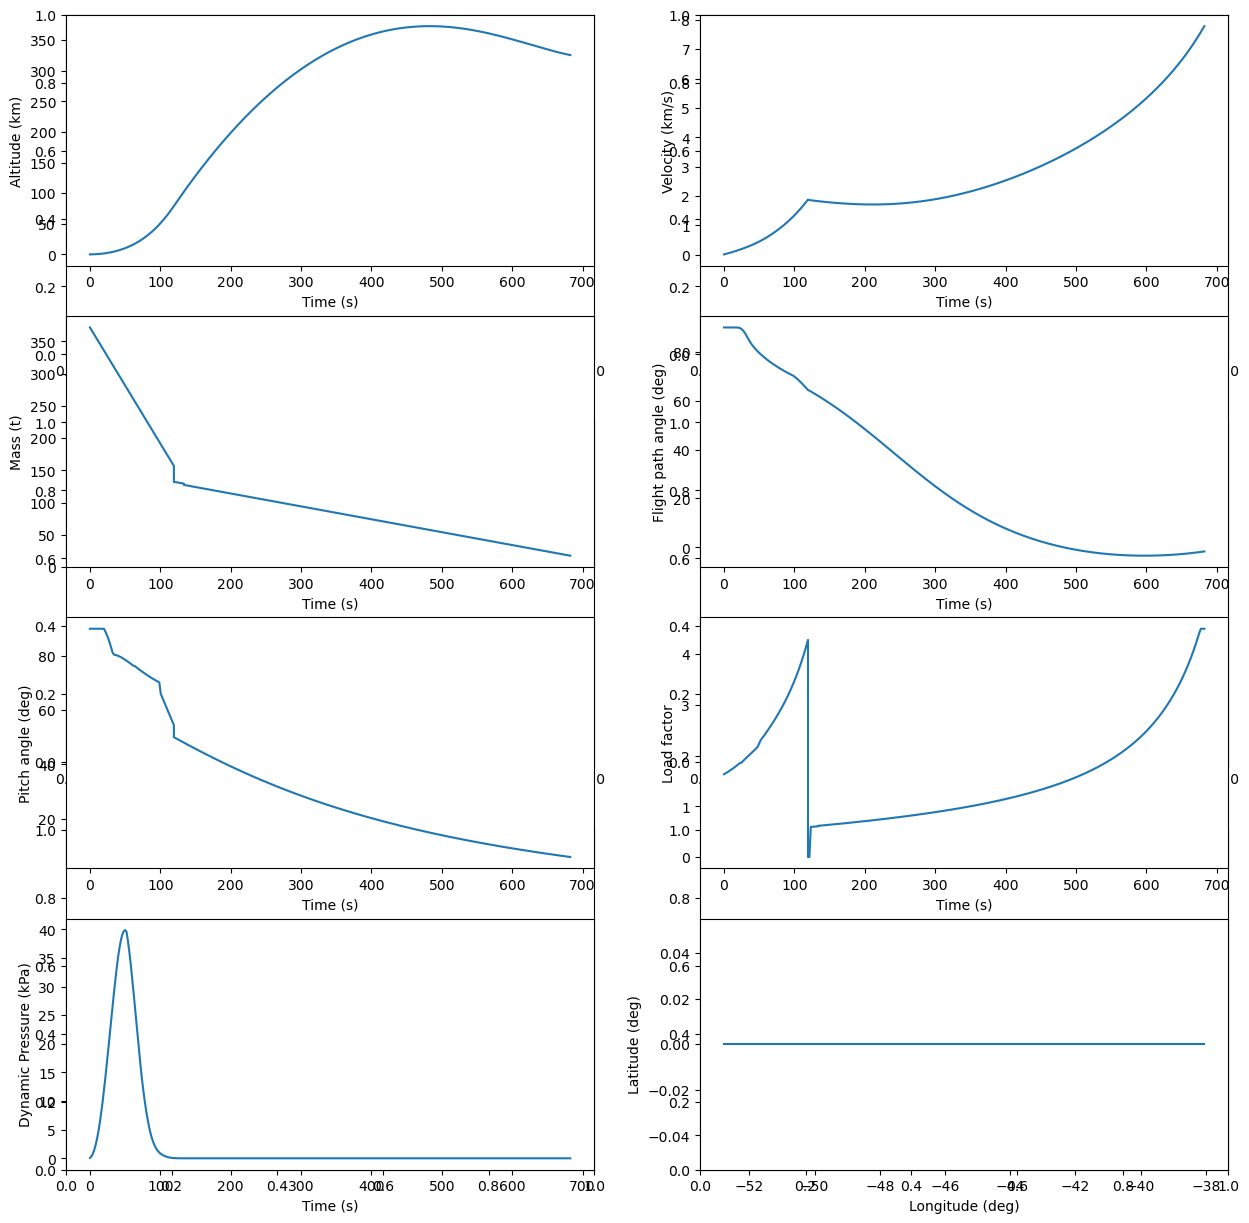

In [14]:
# Setup CMA-ES optimization
print("\n" + "="*60)
print("OPTIMIZATION SETUP")
print("="*60)

# CMA-ES options
lower = np.zeros([1, len(lowerbnd_exp)])
upper = np.ones([1, len(upperbnd_exp)])  
bound_cma = np.array([lower[0], upper[0]])

options = {
    'ftarget': -1e7,       # Target (not used in practice)
    'tolfun': 1e-5,        # Function tolerance
    'tolx': 1e-6,          # Variable tolerance
    'seed': 2,             # Random seed for reproducibility
    'bounds': [bound_cma[0], bound_cma[1]],
    'popsize': 16,         # Increased for more design variables
    'maxiter': 150,        # More iterations for material optimization
    'verb_disp': 1         # Display progress
}

# Choose optimization mode
optimization_mode = input("\nSelect optimization mode:\n"
                         "1. Minimize LCA only\n"
                         "2. Multi-objective (LCA + GLOW)\n"
                         "Enter choice (1 or 2): ")

if optimization_mode == "2":
    w_lca = float(input("Enter LCA weight (0-1, default 0.7): ") or "0.7")
    w_glow = 1.0 - w_lca
    print(f"Using weights: LCA={w_lca:.2f}, GLOW={w_glow:.2f}")
    critere_cma = lambda x: Objective_function_multiobjective(x, lowerbnd_exp, upperbnd_exp, 
                                                             P_obj, w_lca, w_glow)
else:
    print("Optimizing for minimum LCA score")
    simu = 0
    critere_cma = lambda x: Objective_function_LCA(x, lowerbnd_exp, upperbnd_exp, P_obj, simu)

# Initial guess (normalized)
init = np.ones(len(lowerbnd_exp)) * 0.5
# Start with mostly aluminum (conservative)
init[-2] = 0.8  # k_SM_thrust_frame normalized
init[-1] = 0.8  # k_SM_interstage normalized

print("\nStarting CMA-ES optimization...")
print("Number of design variables:", len(lowerbnd_exp))

# Run optimization
res = cma.fmin(critere_cma, init, 0.2, options)

# Results analysis
print("\n" + "="*60)
print("OPTIMIZATION RESULTS")
print("="*60)

print('Optimal design variable values:', res[0])

# Evaluate optimal solution
simu = 1
LCA_opt, GLOW_opt, constraints_check = Objective_function_LCA(res[0], lowerbnd_exp, upperbnd_exp, 
                                                              P_obj, simu)

print(f"\nOptimal LCA Score: {LCA_opt:.2f}")
print(f"Optimal GLOW: {GLOW_opt/1e3:.2f} tonnes")

# Get detailed results
P_out_opt = FPI_optim(res[0], lowerbnd_exp, upperbnd_exp, P_obj)

# Material composition results
XX_opt = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp) * res[0]
k_SM_tf_opt = XX_opt[10]
k_SM_is_opt = XX_opt[11]

al_frac_tf_opt = (k_SM_tf_opt - 0.62) / 0.38
comp_frac_tf_opt = 1.0 - al_frac_tf_opt
al_frac_is_opt = (k_SM_is_opt - 0.7) / 0.3
comp_frac_is_opt = 1.0 - al_frac_is_opt

print(f"\nOptimal Material Composition:")
print(f"Thrust Frame: {al_frac_tf_opt*100:.1f}% Al, {comp_frac_tf_opt*100:.1f}% Composite")
print(f"Interstage: {al_frac_is_opt*100:.1f}% Al, {comp_frac_is_opt*100:.1f}% Composite")

# Detailed results table
data_opt = [[
    P_out_opt['GLOW'][0]/1e3,
    P_out_opt['Dry_mass_stage_1'][0]/1e3,
    P_out_opt['Dry_mass_stage_2'][0]/1e3,
    P_out_opt['Prop_mass_stage_1'][0]/1e3,
    P_out_opt['Prop_mass_stage_2'][0]/1e3,
    P_out_opt['Environmental.LCA_score'][0]/1e3,
    P_out_opt['Environmental.CO2_eq'][0]/1e3,
    P_out_opt['Environmental.Energy_consumption'][0]/1e6
]]

df_opt = pd.DataFrame(data_opt, columns=[
    "GLOW (t)", "Dry_mass_1 (t)", "Dry_mass_2 (t)", 
    "Prop_mass_1 (t)", "Prop_mass_2 (t)",
    "LCA Score", "CO2 eq (t)", "Energy (TJ)"
])

print("\nOptimized Design:")
print(df_opt.round(3))

# Environmental breakdown
print("\n" + "="*60)
print("ENVIRONMENTAL IMPACT BREAKDOWN")
print("="*60)
print(f"Stage 1 LCA: {P_out_opt['Environmental.LCA_stage_1'][0]:.2f}")
print(f"Stage 2 LCA: {P_out_opt['Environmental.LCA_stage_2'][0]:.2f}")
print(f"Propellants LCA: {P_out_opt['Environmental.LCA_propellants'][0]:.2f}")

# Plot results
result_vizualization.plots_output(P_out_opt)

# Save results
results_dict = {
    'design_variables': res[0],
    'GLOW_kg': P_out_opt['GLOW'][0],
    'LCA_score': P_out_opt['Environmental.LCA_score'][0],
    'CO2_eq_kg': P_out_opt['Environmental.CO2_eq'][0],
    'Energy_MJ': P_out_opt['Environmental.Energy_consumption'][0],
    'k_SM_thrust_frame': k_SM_tf_opt,
    'k_SM_interstage': k_SM_is_opt,
    'Al_fraction_thrust_frame': al_frac_tf_opt,
    'Al_fraction_interstage': al_frac_is_opt
}


OPTIMIZATION SETUP
Using weights: LCA=0.70, GLOW=0.30

Starting CMA-ES optimization...
Number of design variables: 12
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=2, Sun Sep 21 18:43:48 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 8.009183060437573e+03 1.0e+00 2.04e-01  2e-01  2e-01 2:02.4
    2     32 8.003241047502306e+03 1.2e+00 1.86e-01  2e-01  2e-01 3:55.8
    3     48 1.009731546013860e+03 1.3e+00 1.87e-01  2e-01  2e-01 5:37.5
    4     64 1.075919802538128e+03 1.3e+00 1.96e-01  2e-01  2e-01 7:36.4
    5     80 1.022323393950461e+03 1.4e+00 2.03e-01  2e-01  2e-01 9:30.7
    6     96 1.009045174208175e+03 1.5e+00 2.06e-01  2e-01  2e-01 11:06.5
    7    112 1.029572041855404e+03 1.6e+00 2.05e-01  2e-01  2e-01 12:43.5
    8    128 1.051430950017795e+03 1.7e+00 2.02e-01  2e-01  2e-01 14:41.2
    9    144 1.015365524776739e+03 1.7e+00 1.99e-01  2e-01  2e-01 16:14.9
   10    160 1.031674142703415e+03 1.7e+00 1.92e-01  2e-01  2

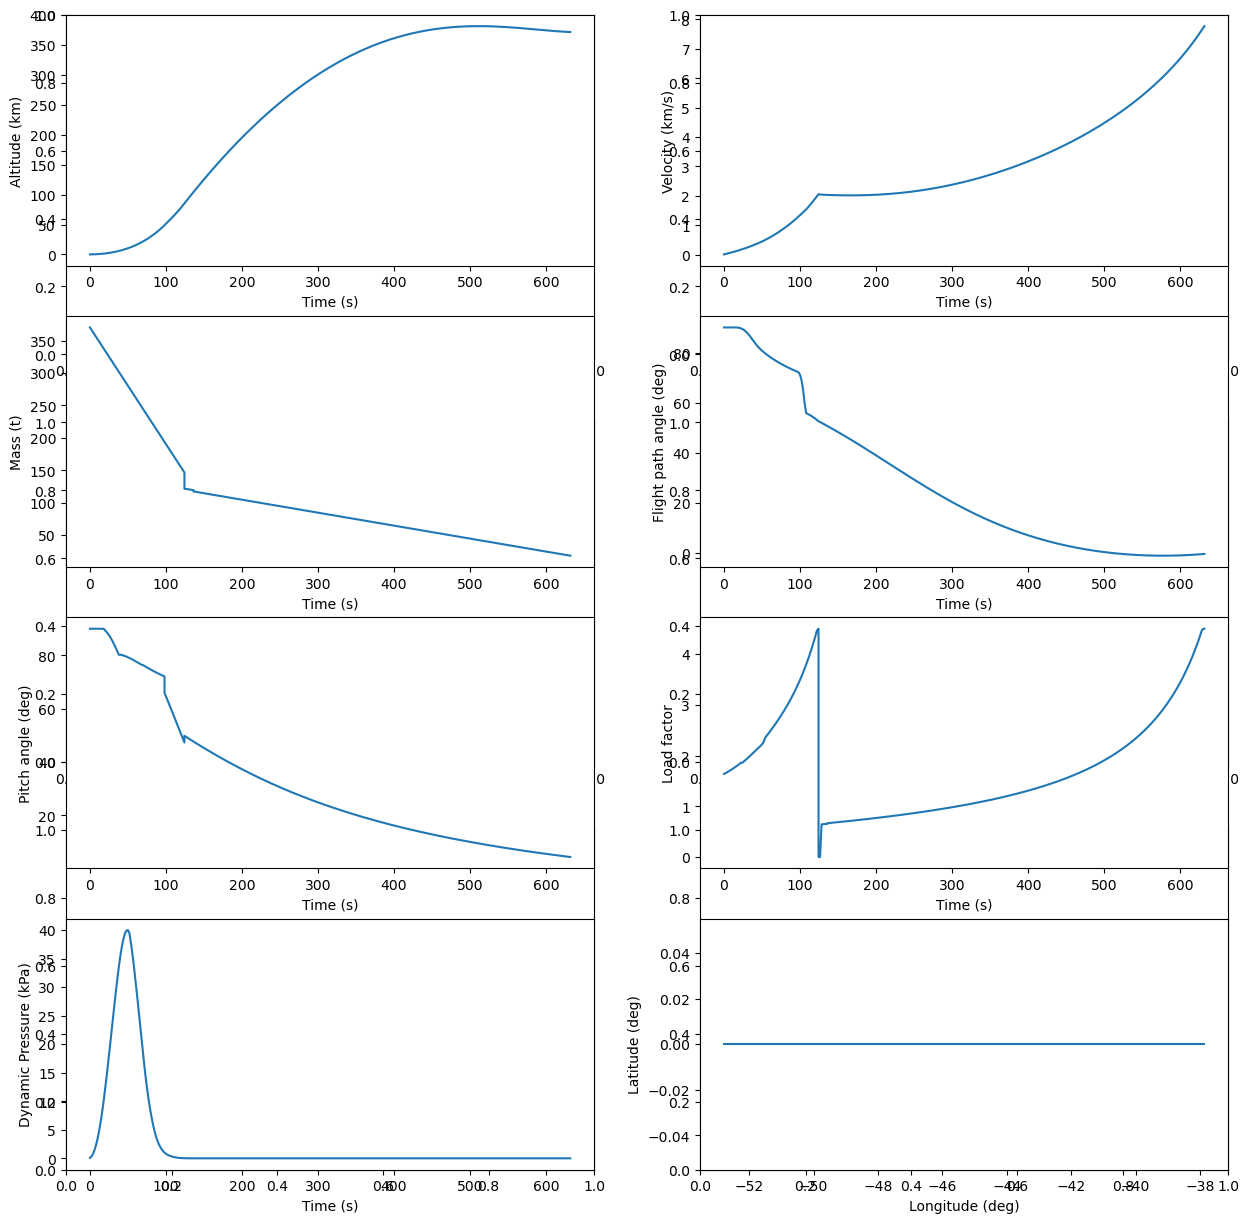

In [17]:
# Setup CMA-ES optimization
print("\n" + "="*60)
print("OPTIMIZATION SETUP")
print("="*60)

# CMA-ES options
lower = np.zeros([1, len(lowerbnd_exp)])
upper = np.ones([1, len(upperbnd_exp)])  
bound_cma = np.array([lower[0], upper[0]])

options = {
    'ftarget': -1e7,       # Target (not used in practice)
    'tolfun': 1e-5,        # Function tolerance
    'tolx': 1e-6,          # Variable tolerance
    'seed': 2,             # Random seed for reproducibility
    'bounds': [bound_cma[0], bound_cma[1]],
    'popsize': 16,         # Increased for more design variables
    'maxiter': 150,        # More iterations for material optimization
    'verb_disp': 1         # Display progress
}

# Choose optimization mode
optimization_mode = input("\nSelect optimization mode:\n"
                         "1. Minimize LCA only\n"
                         "2. Multi-objective (LCA + GLOW)\n"
                         "Enter choice (1 or 2): ")

if optimization_mode == "2":
    w_lca = float(input("Enter LCA weight (0-1, default 0.7): ") or "0.7")
    w_glow = 1.0 - w_lca
    print(f"Using weights: LCA={w_lca:.2f}, GLOW={w_glow:.2f}")
    critere_cma = lambda x: Objective_function_multiobjective(x, lowerbnd_exp, upperbnd_exp, 
                                                             P_obj, w_lca, w_glow)
else:
    print("Optimizing for minimum LCA score")
    simu = 0
    critere_cma = lambda x: Objective_function_LCA(x, lowerbnd_exp, upperbnd_exp, P_obj, simu)

# Initial guess (normalized)
init = np.ones(len(lowerbnd_exp)) * 0.5
# Start with mostly aluminum (conservative)
init[-2] = 0.8  # k_SM_thrust_frame normalized
init[-1] = 0.8  # k_SM_interstage normalized

print("\nStarting CMA-ES optimization...")
print("Number of design variables:", len(lowerbnd_exp))

# Run optimization
res = cma.fmin(critere_cma, init, 0.2, options)

# Results analysis
print("\n" + "="*60)
print("OPTIMIZATION RESULTS")
print("="*60)

print('Optimal design variable values:', res[0])

# Evaluate optimal solution
simu = 1
LCA_opt, GLOW_opt, constraints_check = Objective_function_LCA(res[0], lowerbnd_exp, upperbnd_exp, 
                                                              P_obj, simu)

print(f"\nOptimal LCA Score: {LCA_opt:.2f}")
print(f"Optimal GLOW: {GLOW_opt/1e3:.2f} tonnes")

# Get detailed results
P_out_opt = FPI_optim(res[0], lowerbnd_exp, upperbnd_exp, P_obj)

# Material composition results
XX_opt = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp) * res[0]
k_SM_tf_opt = XX_opt[10]
k_SM_is_opt = XX_opt[11]

al_frac_tf_opt = (k_SM_tf_opt - 0.62) / 0.38
comp_frac_tf_opt = 1.0 - al_frac_tf_opt
al_frac_is_opt = (k_SM_is_opt - 0.7) / 0.3
comp_frac_is_opt = 1.0 - al_frac_is_opt

print(f"\nOptimal Material Composition:")
print(f"Thrust Frame: {al_frac_tf_opt*100:.1f}% Al, {comp_frac_tf_opt*100:.1f}% Composite")
print(f"Interstage: {al_frac_is_opt*100:.1f}% Al, {comp_frac_is_opt*100:.1f}% Composite")

# Detailed results table
data_opt = [[
    P_out_opt['GLOW'][0]/1e3,
    P_out_opt['Dry_mass_stage_1'][0]/1e3,
    P_out_opt['Dry_mass_stage_2'][0]/1e3,
    P_out_opt['Prop_mass_stage_1'][0]/1e3,
    P_out_opt['Prop_mass_stage_2'][0]/1e3,
    P_out_opt['Environmental.LCA_score'][0]/1e3,
    P_out_opt['Environmental.CO2_eq'][0]/1e3,
    P_out_opt['Environmental.Energy_consumption'][0]/1e6
]]

df_opt = pd.DataFrame(data_opt, columns=[
    "GLOW (t)", "Dry_mass_1 (t)", "Dry_mass_2 (t)", 
    "Prop_mass_1 (t)", "Prop_mass_2 (t)",
    "LCA Score", "CO2 eq (t)", "Energy (TJ)"
])

print("\nOptimized Design:")
print(df_opt.round(3))

# Environmental breakdown
print("\n" + "="*60)
print("ENVIRONMENTAL IMPACT BREAKDOWN")
print("="*60)
print(f"Stage 1 LCA: {P_out_opt['Environmental.LCA_stage_1'][0]:.2f}")
print(f"Stage 2 LCA: {P_out_opt['Environmental.LCA_stage_2'][0]:.2f}")
print(f"Propellants LCA: {P_out_opt['Environmental.LCA_propellants'][0]:.2f}")

# Plot results
result_vizualization.plots_output(P_out_opt)

# Save results
results_dict = {
    'design_variables': res[0],
    'GLOW_kg': P_out_opt['GLOW'][0],
    'LCA_score': P_out_opt['Environmental.LCA_score'][0],
    'CO2_eq_kg': P_out_opt['Environmental.CO2_eq'][0],
    'Energy_MJ': P_out_opt['Environmental.Energy_consumption'][0],
    'k_SM_thrust_frame': k_SM_tf_opt,
    'k_SM_interstage': k_SM_is_opt,
    'Al_fraction_thrust_frame': al_frac_tf_opt,
    'Al_fraction_interstage': al_frac_is_opt
}

In [16]:
print("\nResults saved to 'optimization_results_LCA.json'")

# Compare with baseline
print("\n" + "="*60)
print("IMPROVEMENT FROM BASELINE")
print("="*60)
baseline_lca = P_out['Environmental.LCA_score'][0]
baseline_glow = P_out['GLOW'][0]

lca_reduction = (baseline_lca - P_out_opt['Environmental.LCA_score'][0]) / baseline_lca * 100
glow_change = (P_out_opt['GLOW'][0] - baseline_glow) / baseline_glow * 100

print(f"LCA Reduction: {lca_reduction:.1f}%")
print(f"GLOW Change: {glow_change:+.1f}%")

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)


Results saved to 'optimization_results_LCA.json'

IMPROVEMENT FROM BASELINE
LCA Reduction: 0.0%
GLOW Change: +0.0%

OPTIMIZATION COMPLETE
